In [3]:
import tensorflow as tf
from tensorflow.python.platform import tf_logging as logging
from tensorflow.contrib.framework.python.ops.variables import get_or_create_global_step
import inception_preprocessing
from inception_v3 import inception_v3, inception_v3_arg_scope
import time
import os
import nbimporter
import matplotlib.pyplot as plt

plt.style.use('ggplot')
slim = tf.contrib.slim

In [17]:
image_size = 299
file_pattern = 'flower_%s_*.tfrecord'
num_classes = 5

labels_to_name = {}
label_file = 'data/labels.txt'
labels = open(label_file, 'r')
for line in labels:
    label, string_name = line.split(':')
    string_name = string_name[:-1] #Remove newline
    labels_to_name[int(label)] = string_name

items_to_descriptions = {
    'image': 'A 3-channel RGB coloured flower image that is either tulips, sunflowers, roses, dandelion, or daisy.',
    'label': 'A label that is as such -- 0:daisy, 1:dandelion, 2:roses, 3:sunflowers, 4:tulips'
}

# Creating A DataSet Object

In [8]:
'''INPUTS:
    - split_name(str): 'train' or 'validation'. Used to get the correct data split of tfrecord files
    - dataset_dir(str): the dataset directory where the tfrecord files are located
    - file_pattern(str): the file name structure of the tfrecord files in order to get the correct data
    - file_pattern_for_counting(str): the string name to identify your tfrecord files for counting
    OUTPUTS:
    - dataset (Dataset): A Dataset class object where we can read its various components for easier batch creation later.'''
    
        
def get_split(split_name, dataset_dir, file_pattern=file_pattern, file_pattern_for_counting='flower'):
    #First check whether the split_name is train or validation
    if split_name not in ['train', 'validation']:
        raise ValueError('The split_name %s is bit recognized.\
                        Please input either train or validation\
                        as the split_name' % (split_name))
    
    #Create the full path for a general file_pattern to locate the tfrecord_files.
    file_pattern_path = os.path.join(dataset_dir, 
                                     file_pattern % (split_name))
    
    # Count the total number of examples in all of these shard
    num_samples = 0
    file_pattern_for_counting = file_pattern_for_counting  + '_' + split_name
    tfrecords_to_count = [os.path.join(dataset_dir, file) for file in os.listdir(dataset_dir) if file.startswith(file_pattern_for_counting)]
    
    for tfrecord_file in tfrecords_to_count:
        for record in tf.python_io.tf_record_iterator(tfrecord_file):
            num_samples += 1
    
    # Create a reader , which must be a TFRecord reader in this case
    reader = tf.TFRecordReader
    
    #Create the keys_to_features dictionary for the decoder
    key_to_features = {
        'image/encoded': tf.FixedLenFeature((), tf.string, default_value=''),
        'image/format': tf.FixedLenFeature((), tf.string, default_value='jpg'),
        'image/class/label': tf.FixedLenFeature(
            [], tf.int64, default_value=tf.zeros([], dtype=tf.int64)),
    }
    
    #Create the items_to_handlers dictionary for the decoder
    items_to_handlers = {
        'image': slim.tfexample_decoder.Image(),
        'label': slim.tfexample_decoder.Tensor('image/class/label'),
    }
    
    # Start to create the decoder
    decoder = slim.tfexample_decoder.TFExampleDecoder(key_to_features, items_to_handlers)
    
    # Create the labels to name file
    labels_to_name_dict = labels_to_name
    
    # Actually create the dataset
    dataset = slim.dataset.Dataset(
            data_sources= file_pattern_path,
            decoder= decoder,
            reader= reader,
            num_reader = 4,
            num_samples = num_samples,
            num_classes = num_classes,
            labels_to_name= labels_to_name_dict,
            items_to_descriptions= items_to_descriptions
    )
    
    return dataset



In [9]:
def load_batch(dataset, batch_size, height=image_size, width=image_size, is_training=True):
    '''
    Loads a batch for training.
    INPUTS:
    - dataset(Dataset): a Dataset class object that is created from the get_split function
    - batch_size(int): determines how big of a batch to train
    - height(int): the height of the image to resize to during preprocessing
    - width(int): the width of the image to resize to during preprocessing
    - is_training(bool): to determine whether to perform a training or evaluation preprocessing
    OUTPUTS:
    - images(Tensor): a Tensor of the shape (batch_size, height, width, channels) that contain one batch of images
    - labels(Tensor): the batch's labels with the shape (batch_size,) (requires one_hot_encoding).
    '''
    
    # Create the data Provider object
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
    dataset,
    common_queue_capacity= 24 + 3 * batch_size,
    common_queue_min = 24)
    
    #obtain the raw image using the get method
    raw_image, label = data_provider.get(['image','label'])
    
    #Perform the correct preprocessing for this image depending if it is training or evaluating
    image = inception_preprocessing.preprocess_image(raw_image, height, width, is_training)
    
    #As for the raw images, we just do a simple reshape to batch it up
    raw_image = tf.expand_dims(raw_image, 0)
    raw_image = tf.image.resize_nearest_neighbor(raw_image, [height,width])
    
    #Batch up the image by enqueing the tensors internally in a FIFO queue and dequeueing many elements with tf.train.batch.
    images, raw_image, labels = tf.train.batch(
                    [image, raw_image, label],
                    batch_size = batch_size,
                    num_threads = 4,
                    capacity = 3 * batch_size,
                    allow_smaller_final_batch = True)
    
    return images, raw_image, labels

# Start

In [31]:
# Log Directory where can retrive model
log_dir = 'log'

# Create new evaluation log directory to visualize the val process
log_eval = 'log_eval_test'

# Dataset Dir where the validation set (TFRecord) is found
dataset_dir = 'data'

# State the num of epochs to evaluate
batch_size = 36

# State the num of epochs to eval
num_epochs = 3

# Get the lastest checkpoingt file
checkpoint_file = tf.train.latest_checkpoint(log_dir)  # <---- Load Model.ckpt


################# RUN ##################
def run():
    #Create Evaluation log_dir Info
    if not os.path.exists(log_eval):
        os.mkdir(log_eval)

    
    #Just construct the graph from scratch again
    with tf.Graph().as_default() as graph:
        tf.logging.set_verbosity(tf.logging.INFO)
        # Get the dataset first and load one batch
        # of val images and labels tensors.
        dataset = get_split('validation', dataset_dir)
        images, raw_images, labels = load_batch(dataset,
                                                batch_size=batch_size,
                                                is_training = False)
        
        # Create some info about the Val steps
        num_batches_per_epoch = dataset.num_samples / batch_size
        num_steps_per_epoch = num_batches_per_epoch
        
        # Create the inference model but set  is_training= False
        with slim.arg_scope(inception_resnet_v2_arg_scope()):
            logits, end_points = inception_resnet_v2(images,
                                                     num_classes=dataset.num_classes,
                                                     is_training = False)

        # Get all the variables to restore from the checkpoint
        # file and create the saver function to restore
        variables_to_restore = slim.get_variables_to_restore()
        saver = tf.train.Saver(variables_to_restore)
        def restore_fn(sess):
            return saver.restore(sess, checkpoint_file)
        
        # Just define the metrics to track without the loss or whatsoever
        predictions = tf.argmax(end_points['Predictions'], 1)
        accuracy, accuracy_update = tf.contrib.metrics.streaming_accuracy(predictions, labels)
        metrics_op = tf.group(accuracy_update)
        
        #Create the global step and an increment op for monitoring
        global_step = get_or_create_global_step()
        #no apply_gradient method so manually increasing the global_step
        global_step_op = tf.assign(global_step,global_step+1)
        
        #Create a eval step func
        def eval_step(sess, metrics_op, global_step):
            '''
            Simply takes in a session, runs the metrics op and some logging information.
            '''
            start_time = time.time()
            _, global_step_count, accuracy_value = sess.run([metrics_op, global_step_op, accuracy])
            
            time_elapsed = time.time() - start_time
            
            #Log some information
            logging.info('Global Step %s: Streaming Accuracy: %.4f (%.2f sec/step)', global_step_count, accuracy_value, time_elapsed)
            
            return accuracy_value
            
        #Define some scalar quantities to monitor
        tf.summary.scalar('Validation_Accuracy', accuracy)
        my_summary_op = tf.summary.merge_all()
        
        # Get your supervisor
        sv = tf.train.Supervisor(logdir = log_eval, summary_op = None, saver = None, init_fn = restore_fn)
        
         #Now we are ready to run in one session
        with sv.managed_session() as sess:
            for step in range(int(num_steps_per_epoch * num_epochs)):
                sess.run(sv.global_step)
                #print vital information every start of the epoch as always
                if step % num_batches_per_epoch == 0:
                    logging.info('Epoch: %s/%s', step / num_batches_per_epoch + 1, num_epochs)
                    logging.info('Current Streaming Accuracy: %.4f', sess.run(accuracy))
                    
                #Compute summaries every 10 steps and continue evaluating
                if step % 10 == 0:
                    eval_step(sess, metrics_op = metrics_op, global_step = sv.global_step)
                    summaries = sess.run(my_summary_op)
                    sv.summary_computed(sess, summaries)
                    

                #Otherwise just run as per normal
                else:
                    eval_step(sess, metrics_op = metrics_op, global_step = sv.global_step)

            #At the end of all the evaluation, show the final accuracy
            logging.info('Final Streaming Accuracy: %.4f', sess.run(accuracy))

            #Now we want to visualize the last batch's images just to see what our model has predicted
            raw_images, labels, predictions = sess.run([raw_images, labels, predictions])
            for i in range(10):
                image, label, prediction = raw_images[i], labels[i], predictions[i]
                prediction_name, label_name = dataset.labels_to_name[prediction], dataset.labels_to_name[label]
                text = 'Prediction: %s \n Ground Truth: %s' %(prediction_name, label_name)
                img_plot = plt.imshow(image.squeeze())

                #Set up the plot and hide axes
                plt.title(text)
                img_plot.axes.get_yaxis().set_ticks([])
                img_plot.axes.get_xaxis().set_ticks([])
                plt.show()

            logging.info('Model evaluation has completed! Visit TensorBoard for more information regarding your evaluation.')
                

INFO:tensorflow:Restoring parameters from log\model.ckpt-17920
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:Epoch: 1.0/3
INFO:tensorflow:Current Streaming Accuracy: 0.0000
INFO:tensorflow:Global Step 1: Streaming Accuracy: 0.0000 (1.90 sec/step)
INFO:tensorflow:Global Step 2: Streaming Accuracy: 0.9722 (0.62 sec/step)
INFO:tensorflow:Global Step 3: Streaming Accuracy: 0.9444 (0.64 sec/step)
INFO:tensorflow:Global Step 4: Streaming Accuracy: 0.9537 (0.66 sec/step)
INFO:tensorflow:Global Step 5: Streaming Accuracy: 0.9514 (0.68 sec/step)
INFO:tensorflow:Global Step 6: Streaming Accuracy: 0.9556 (0.66 sec/step)
INFO:tensorflow:Global Step 7: Streaming Accuracy: 0.9537 (0.68 sec/step)
INFO:tensorflow:Global Step 8: Streaming Accuracy: 0.9524 (0.67 sec/step)
INFO:tensorflow:Global Step 9: Streaming Accuracy: 0.9549 (0.67

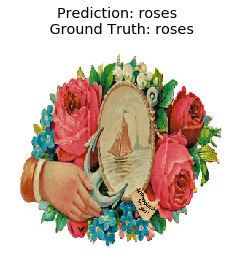

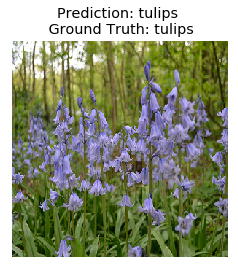

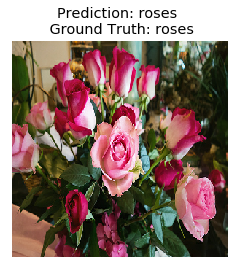

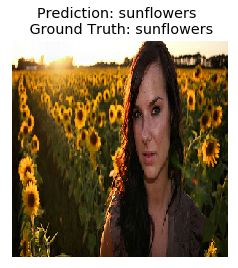

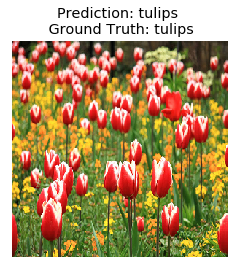

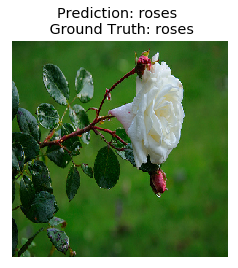

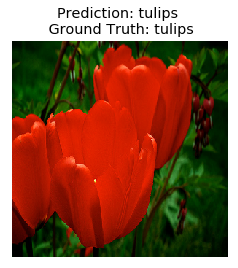

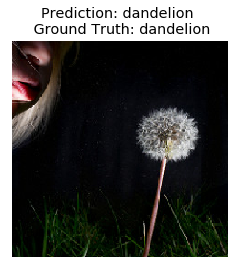

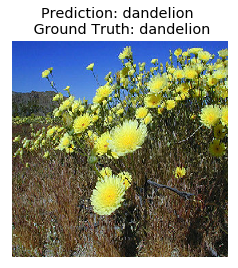

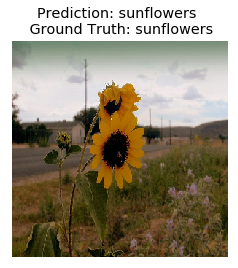

INFO:tensorflow:Model evaluation has completed! Visit TensorBoard for more information regarding your evaluation.


In [32]:
run()